# GATA2 interactome
1. Start with stable GATA2 regulon (217 genes)
2. Get their ens_ids
3. Get all their interactions (281 unique)
4. Get all genes participating in these interactions (112/108)
5. In selected GO (79/68 genes)
6. Overlap with some marker genes (not clear, I can get 15, Stephane used 12 for figures)

In [21]:
import scanpy as sc
import requests
import json
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
def requestString(genes,method,
                  species=9606,
                  output_format = "tsv",
                  string_api_url = "https://version-11-5.string-db.org/api",
                  caller_identity = "www.awesome_app.org"):
    ## Construct URL
    request_url = "/".join([string_api_url, output_format, method])
    ## Set parameters
    params = {
        "identifiers" : "%0d".join(genes), # your protein
        "species" : species, # species NCBI identifier 
        "caller_identity" : caller_identity # your app name
    }
    ## Call STRING
    response = requests.post(request_url, data=params)
    result = response.text
    if output_format == 'tsv': 
        lines = result.strip().split("\n")
        result = pd.DataFrame([r.split('\t') for r in lines[1:]],columns=lines[0].split('\t')).drop_duplicates()
    elif output_format == 'json':
        result = json.loads(result)
    return result

In [3]:
def string2graph(d,n1='preferredName_A',n2='preferredName_B',weight='score'):
    g = nx.Graph()
    for i in range(d.shape[0]):
        g.add_edge(d.iloc[i,:][n1], d.iloc[i,:][n2],weight=d.iloc[i,:][weight])
    return g

# Select genes to show

## Manually selected gene/go lists
the lists are from Stephane, I'm not sure how he got them

In [4]:
angioTerms = ['GO:0045765','GO:0001568','GO:0030334','GO:0010646','GO:0001936','GO:0045446','GO:0002040','GO:0030155','GO:0010941','GO:0030198']

In [5]:
arterioleTrajGenes = ['HPGD','ITM2A','SLC7A5','TMEM176B','APLNR','SLC38A5','HAPLN3','MFSD2A',
                      'LGALS1','MMP1','PRSS23','PGF','PRSS2','GYPC','HLA−C','COL4A1','SPARCL1',
                      'HLA−B','PRND','CAV1','IGF2','AQP1','IGFBP3','GJA5','FBLN5','CXCL12','TMEM100','SRGN']
venuleTrajGenes = ['ITM2A','SLC7A5','HPGD','SYT1','CDH2','SLC38A5','ECM1','LGALS1','ESM1','CXCR4','PDLIM2',
                   'PGF','PRSS23','NOV','COL4A1','IGF2','FABP4','IL32','IGFBP7','CAV1','SPARC','BCAM','IL33',
                   'LGALS3','VWF','SELE','ACKR1','PLVAP','CPE','FBLN2','CLU','MMRN1','VCAN','ELN']
capArtMarkers = ['PRND','GPIHBP1','GFBP3','LY6H','CXCR4']
vegf = ['VEGFA','VEGFB','VEGFC','VEGFD','FLT1','KDR','FLT4']

## GATA regulon

In [6]:
with open('stable_regulons_rss.pk', 'rb') as handle:
    rssnf = pickle.load(handle)
rssnf

,fetal_Adipocytes,organoid_Adipocytes,fetal_Basal,organoid_Basal,fetal_Capillary arterioles,organoid_Capillary arterioles,fetal_Companion layer,organoid_Companion layer,fetal_Cuticle/cortex,organoid_Cuticle/cortex,...,fetal_Periderm,organoid_Periderm,fetal_Pre-dermal condensate,organoid_Pre-dermal condensate,fetal_SPP1+ Neuron progenitors,organoid_SPP1+ Neuron progenitors,fetal_Schwann/Schwann precursors,organoid_Schwann/Schwann precursors,fetal_Suprabasal IFE,organoid_Suprabasal IFE
ALX1(+),0.179453,0.178379,0.190822,0.181752,0.185720,0.177817,0.171257,0.179816,0.170924,0.171995,...,0.175378,0.178224,0.189081,0.179678,0.202051,0.189092,0.203198,0.192063,0.171003,0.176839
ALX4(+),0.199920,0.211321,0.188657,0.196033,0.177755,0.175123,0.171381,0.186852,0.171335,0.201149,...,0.179579,0.184972,0.203081,0.222169,0.183000,0.192328,0.183435,0.188068,0.170934,0.183863
AR(+),0.247102,0.277241,0.176883,0.205102,0.198898,0.187579,0.169712,0.182003,0.168512,0.173966,...,0.177456,0.176931,0.215611,0.233147,0.178981,0.188433,0.200894,0.200050,0.168532,0.180484
ARID3A(+),0.188975,0.194963,0.186726,0.200193,0.190588,0.191901,0.174450,0.212589,0.171434,0.202723,...,0.210658,0.245488,0.192233,0.199438,0.183363,0.189317,0.183094,0.189091,0.177057,0.224221
ARNT2(+),0.201009,0.194660,0.185158,0.185497,0.187917,0.180801,0.171060,0.183540,0.170215,0.183701,...,0.192461,0.198544,0.198959,0.190675,0.214242,0.221827,0.230538,0.226964,0.171909,0.185787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD1(+),0.206644,0.199335,0.198269,0.195037,0.246676,0.217396,0.172809,0.190434,0.171754,0.184822,...,0.185267,0.188849,0.207384,0.202026,0.200458,0.200070,0.209626,0.201075,0.172623,0.189577
STAT5B(+),0.203524,0.233081,0.185603,0.197665,0.185867,0.172280,0.171703,0.192045,0.170502,0.182198,...,0.188902,0.181981,0.181116,0.199394,0.185656,0.184574,0.190672,0.180153,0.172415,0.193564
TEF(+),0.237568,0.191001,0.182758,0.194717,0.179432,0.173048,0.178801,0.217066,0.172538,0.203309,...,0.187299,0.206141,0.193659,0.188931,0.189110,0.186563,0.189277,0.186064,0.178032,0.244295
ZBTB14(+),0.192803,0.198124,0.195968,0.205020,0.187840,0.187002,0.172972,0.197718,0.170326,0.196977,...,0.184316,0.189205,0.190615,0.206862,0.188861,0.194217,0.190119,0.192569,0.173789,0.191205


In [7]:
topRegs = rssnf['fetal_Capillary arterioles'].sort_values(ascending=False).index[:10]
topRegs = [x.replace('(+)','') for x in topRegs]
topRegs

['MECOM',
 'ELF4',
 'SOX7',
 'HOXD10',
 'TAL1',
 'GATA2',
 'BCL6B',
 'SMAD1',
 'ERG',
 'ELK3']

## GATA stable regulon from 01.stable_regulons.ipynb

In [8]:
gataRegulon = pd.read_csv('regulons_stable_80pct_GATA2_stringDbQuery.csv',index_col=0)
gataRegulon = gataRegulon.rename({'0':'gene_name'},axis=1)
gataRegulon

,gene_name
0,RASGRP3
1,EMCN
2,LIMS1
3,FLI1
4,CXorf36
...,...
212,TM4SF18
213,PREX2
214,RIMKLB
215,TRAF3IP2


## Interact with GATA

In [9]:
gataRegInter = requestString(gataRegulon.gene_name,'network')
gataRegInter

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000046794,9606.ENSP00000255945,LCP2,GIMAP4,9606,0.445,0,0,0,0.404,0,0,0.107
2,9606.ENSP00000046794,9606.ENSP00000386884,LCP2,CXCR4,9606,0.47,0,0,0,0.18,0,0,0.381
4,9606.ENSP00000046794,9606.ENSP00000264832,LCP2,ICAM1,9606,0.582,0,0,0,0.088,0,0,0.56
6,9606.ENSP00000046794,9606.ENSP00000472249,LCP2,GMFG,9606,0.595,0,0,0,0.568,0,0,0.1
8,9606.ENSP00000046794,9606.ENSP00000386911,LCP2,ARHGAP25,9606,0.601,0,0,0,0.548,0,0,0.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,9606.ENSP00000393776,9606.ENSP00000406209,FCHO2,EPN1,9606,0.814,0,0,0,0.062,0,0.6,0.546
554,9606.ENSP00000415283,9606.ENSP00000457421,ICAM2,PECAM1,9606,0.75,0,0,0,0.157,0,0,0.715
556,9606.ENSP00000433488,9606.ENSP00000457421,FLI1,PECAM1,9606,0.409,0,0,0,0.14,0,0,0.341
558,9606.ENSP00000457421,9606.ENSP00000475344,PECAM1,APLNR,9606,0.545,0,0,0,0.069,0,0,0.531


In [11]:
# find these of them who interact with GATA (even indirectly)
GataInterExp = {'GATA2'}
while(True):
    s = len(GataInterExp)
    GataInterExp.update(gataRegInter.preferredName_A[gataRegInter.preferredName_B.isin(GataInterExp)])
    GataInterExp.update(gataRegInter.preferredName_B[gataRegInter.preferredName_A.isin(GataInterExp)])
    if(s == len(GataInterExp)):
        break
gataRegulon['is_GataInterExp'] = gataRegulon.gene_name.isin(GataInterExp)
gataRegulon['is_GataInterExp'].value_counts()

True     109
False    108
Name: is_GataInterExp, dtype: int64

In [12]:
# something funny with String, it should return only interactions between query genes..
GataInterExp- set(gataRegulon.gene_name)

{'GPR116', 'GPR124', 'LPPR5'}

## In angiogenesis GO

In [13]:
gataRegGO = requestString(gataRegulon.gene_name,'enrichment',output_format='json')

gene2go = []
for go in gataRegGO:
    term = go['term']
    for gene in go['inputGenes']:
        gene2go.append([term,gene])
gene2go = pd.DataFrame(gene2go,columns=['term','gene'])
gene2go

,term,gene
0,GO:0009653,RELT
1,GO:0009653,BCL3
2,GO:0009653,HBEGF
3,GO:0009653,HES1
4,GO:0009653,INHBA
...,...,...
8915,EFO:0007978,PRKAR1B
8916,EFO:0007978,FCHO2
8917,EFO:0007978,TPRXL
8918,EFO:0007978,ERG


In [14]:
agids = set(gene2go[gene2go.term.isin(angioTerms)].gene)
gataRegulon['is_angioGO'] = gataRegulon.gene_name.isin(agids)
pd.crosstab(gataRegulon['is_angioGO'],gataRegulon['is_GataInterExp'])

is_GataInterExp,False,True
is_angioGO,,
False,80,41
True,28,68


## In marker genes

In [15]:
all = topRegs  + arterioleTrajGenes + venuleTrajGenes + vegf
gataRegulon['is_markerGenes'] = gataRegulon.gene_name.isin(all)
f = gataRegulon['is_angioGO'] & gataRegulon['is_GataInterExp'] & gataRegulon['is_markerGenes']
f.value_counts()

False    205
True      12
dtype: int64

In [16]:
gataRegulon.gene_name[f]
# compared to 12
# - SOX17 (in top 11)
# + ESM1

13       VWF
41      FLT1
55      TAL1
63      SOX7
75     CXCR4
76     MECOM
83     GATA2
87      CAV1
114     ESM1
127      KDR
154    APLNR
168     AQP1
Name: gene_name, dtype: object

In [17]:
# 12 genes for figure
genes = ['GATA2','MECOM','SOX17','TAL1','SOX7','APLNR','KDR','FLT1','CXCR4','VWF','CAV1','AQP1']

In [18]:
set(gataRegulon.gene_name[f]) - set(genes)

{'ESM1'}

In [19]:
set(genes) - set(gataRegulon.gene_name[f])

{'SOX17'}

## In expressed

In [25]:
fo_ad = sc.read_h5ad('../../../data.nfs/from.stephane/skin/20201107_organoid_cellphonedb/pooled_endothelium.processed.h5ad')
gataRegulon['is_expressed'] = gataRegulon.gene_name.isin(fo_ad.var_names)

/nfs/cellgeni/pasham/miniconda3/envs/pyscenic/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/nfs/cellgeni/pasham/miniconda3/envs/pyscenic/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [26]:
gataRegulon[f]

,gene_name,is_GataInterExp,is_angioGO,is_markerGenes,is_expressed
13,VWF,True,True,True,True
41,FLT1,True,True,True,True
55,TAL1,True,True,True,True
63,SOX7,True,True,True,True
75,CXCR4,True,True,True,True
76,MECOM,True,True,True,True
83,GATA2,True,True,True,True
87,CAV1,True,True,True,True
114,ESM1,True,True,True,True
127,KDR,True,True,True,True


# From 12 genes

## Construct graph from genes using String interactions

In [49]:
genes = ['GATA2','MECOM','SOX17','TAL1','SOX7','APLNR','KDR','FLT1','CXCR4','VWF','CAV1','AQP1']

In [50]:
network1 = requestString(genes,'network')
for f in ['score','nscore','fscore','pscore','ascore','escore','dscore','tscore']:
    network1[f] = network1[f].astype('float')
network1.head()

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000261405,9606.ENSP00000339191,VWF,CAV1,9606,0.429,0.0,0.0,0.0,0.052,0.0,0.0,0.423
2,9606.ENSP00000261405,9606.ENSP00000475344,VWF,APLNR,9606,0.444,0.0,0.0,0.0,0.338,0.0,0.0,0.195
4,9606.ENSP00000261405,9606.ENSP00000386884,VWF,CXCR4,9606,0.544,0.0,0.0,0.0,0.062,0.0,0.0,0.533
6,9606.ENSP00000261405,9606.ENSP00000311165,VWF,AQP1,9606,0.669,0.0,0.0,0.0,0.570,0.0,0.0,0.261
8,9606.ENSP00000261405,9606.ENSP00000282397,VWF,FLT1,9606,0.702,0.0,0.0,0.0,0.142,0.0,0.0,0.667


In [51]:
gos = requestString(genes,'enrichment',output_format='json')
gos[0]

{'category': 'Process',
 'term': 'GO:0001525',
 'number_of_genes': 7,
 'number_of_genes_in_background': 315,
 'ncbiTaxonId': 9606,
 'inputGenes': ['KDR', 'FLT1', 'TAL1', 'SOX17', 'CAV1', 'GATA2', 'APLNR'],
 'preferredNames': ['KDR', 'FLT1', 'TAL1', 'SOX17', 'CAV1', 'GATA2', 'APLNR'],
 'p_value': 2.25e-10,
 'fdr': 2.89e-06,
 'description': 'Angiogenesis'}

In [52]:
graph1 = string2graph(network1)

In [53]:
widths = nx.get_edge_attributes(graph1,'weight')
widths = [6*(widths[e]-0.2) for e in graph1.edges]

## Annotate nodes

In [54]:
nodes = pd.DataFrame(list(graph1.nodes),columns=['gene_name'])
nodes['topRegs'] = (nodes.gene_name+'(+)').isin(topRegs)
# SOX17 is 11th
nodes['endo_trajectories'] = nodes.gene_name.isin(arterioleTrajGenes+venuleTrajGenes)
nodes['colour'] = '#ffffff'
nodes.loc[nodes.topRegs,'colour'] = '#fdd8a5'
nodes.loc[nodes.endo_trajectories,'colour'] = '#b3cce1'
# add " importance of a gene in angiogenesis as measured by the proportion of GO terms it belongs to (out of 34)"
# this table from created by Stephane, I do not know how
goprops = pd.read_excel('fig5k_dev_enrTable_LG_SB_yellow_nbTermByGene.xlsx')
goprops=goprops.set_index('gene')
nodes['propNbTerms'] = goprops.loc[nodes.gene_name,'propNbTerms'].values
nodes 

,gene_name,topRegs,endo_trajectories,colour,propNbTerms
0,VWF,False,True,#b3cce1,0.029412
1,CAV1,False,True,#b3cce1,0.441176
2,APLNR,False,True,#b3cce1,0.323529
3,CXCR4,False,True,#b3cce1,0.323529
4,AQP1,False,True,#b3cce1,0.117647
5,FLT1,False,False,#ffffff,0.500000
6,KDR,False,False,#ffffff,0.852941
7,SOX7,False,False,#ffffff,0.058824
8,GATA2,False,False,#ffffff,0.647059
9,SOX17,False,False,#ffffff,0.294118


### Add number of angiogenesis GO terms

In [58]:
# check terms that have angiogenesis in their description
[[g['term'],g['description']] for g in gos if 'angiogenesis' in g['description'].lower() ]

[['GO:0001525', 'Angiogenesis'],
 ['GO:0045766', 'Positive regulation of angiogenesis'],
 ['GO:1903672', 'Positive regulation of sprouting angiogenesis'],
 ['GO:1903589',
  'Positive regulation of blood vessel endothelial cell proliferation involved in sprouting angiogenesis'],
 ['GO:0090050',
  'Positive regulation of cell migration involved in sprouting angiogenesis'],
 ['KW-0037', 'Angiogenesis'],
 ['PMID:34530889',
  '(2021) KAI1(CD82) is a key molecule to control angiogenesis and switch angiogenic milieu to quiescent state.'],
 ['PMID:35508511',
  '(2022) The transcription factor complex LMO2TAL1 regulates branching and endothelial cell migration in sprouting angiogenesis.'],
 ['PMID:20071503',
  '(2010) A sex-specific role for androgens in angiogenesis.'],
 ['PMID:28577909',
  '(2017) SOX7 expression is critically required in FLK1-expressing cells for vasculogenesis and angiogenesis during mouse embryonic development.'],
 ['WP1539', 'Angiogenesis']]

In [61]:
gene2go[gene2go.term.isin(angioTerms)].groupby('gene').size()[genes]

gene
GATA2    5
MECOM    1
SOX17    3
TAL1     2
SOX7     1
APLNR    4
KDR      9
FLT1     6
CXCR4    5
VWF      1
CAV1     6
AQP1     1
dtype: int64

In [62]:
gene2go.groupby('gene').size()[genes]

gene
GATA2    167
MECOM     73
SOX17    125
TAL1     134
SOX7      76
APLNR    105
KDR      213
FLT1     140
CXCR4    132
VWF       98
CAV1     129
AQP1      62
dtype: int64

## Plot

(0.0, 6.0)

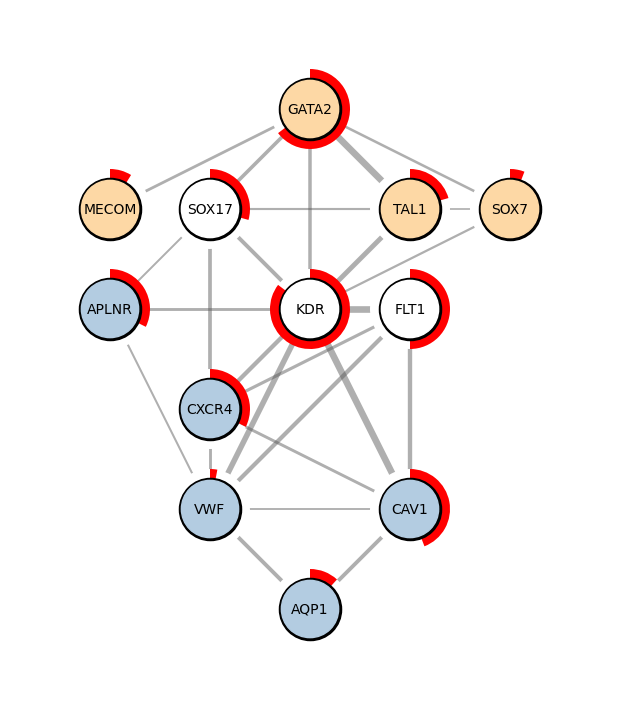

In [145]:
plt.rcParams['figure.figsize'] = [6, 7]
pos = {'GATA2':(3,6),
       'MECOM':(1,5),
       'SOX17':(2,5),
       'TAL1' :(4,5),
       'SOX7' :(5,5),
       'APLNR':(1,4),
       'KDR'  :(3,4),
       'FLT1' :(4,4),
       'CXCR4':(2,3),
       'VWF'  :(2,2),
       'CAV1' :(4,2),
       'AQP1' :(3,1)}
nx.draw(graph1,pos=pos, font_weight='bold', node_color="black",width=widths,edge_color='#55555577',node_size=2000)
for i in range(nodes.shape[0]):
    f = nodes.propNbTerms[i]
    a = plt.pie([1-f,f],
                startangle = 90,
                center=pos[nodes.gene_name[i]],
                colors = ['white','red'],
                radius=0.4)

nx.draw_networkx_nodes(graph1,pos=pos,node_color='black',node_size=1800)
nx.draw_networkx_nodes(graph1,pos=pos,node_color=nodes.colour,node_size=1700)
z=nx.draw_networkx_labels(graph1,pos=pos, font_color="black",font_size=10)

plt.ylim(0,7)
plt.xlim(0,6)